<a href="https://colab.research.google.com/github/hinsley/colabs/blob/master/Coronavirus_Projections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### To Do

- [ ] Improve projections.
- [ ] Change 68% confidence interval error bars to 95% or 99.7%.
- [ ] Add US states projections for confirmed cases & deaths.
- [ ] Add Canadian provincial projections for confirmed cases & deaths.

### What can be done to improve projections?

- [ ] Do not factor zero values into dataset to fit curve to.
- [ ] Fit derivative curve instead of sigmoid curve.
- [ ] Try weighting newer values as more important.
- [ ] Use lognormal probability density function instead of sigmoid.

In [1]:
!pip install uncertainties

In [0]:
from uncertainties import ufloat
import numpy as np
import pandas as pd
from uncertainties import unumpy as unp
import math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from datetime import date, datetime, timedelta

In [0]:
def sigmoid(x, a, b, c):
  """
  Args:
  - x: Time input.
  - a: Horizontal translation (positive: right).
  - b: Vertical scalar.
  - c: Horizontal scalar.
  """

  result = b * (1-1/(1+np.exp(c * (x - a))))

  return result

def usigmoid(x, a, b, c):
  result = b * (1-1/(1+unp.exp(c * (x - a))))

  return result


# Finding projective maximum spread rate

$\sigma = b \left(1 - \frac{1}{1 + e^{c(x - a)}}\right)$

The maximum spread rate can be found by the spread rate $\sigma_x(x_\text{inflection})$ where
$\sigma_{xx}(x_\text{inflection}) = 0$.

$\sigma_x = -b \frac{\partial}{\partial x} \frac{1}{1+e^{c(x-a)}}$

$= b \frac{1}{(1+e^{c(x-a)})^2} \frac{\partial}{\partial x}(1+e^{c(x-a)})$

$= \frac{b}{(1+e^{c(x-a)})^2e^{ac}} \frac{\partial}{\partial x}(e^{cx})$

$= bc \frac{e^{c(x-a)}}{(1+e^{c(x-a)})^2}$

$= bc \frac{1 + e^{c(x-a)} - 1}{(1+e^{c(x-a)})^2}$

$= bc \left( \frac{1}{1 + e^{c(x-a)}} - \frac{1}{(1+e^{c(x-a)})^2} \right)$

$= bc \frac{1}{1+e^{c(x-a)}} \left( 1 - \frac{1}{1+e^{c(x-a)}} \right)$

$\sigma_x = \frac{c}{b} \sigma (b - \sigma)$

$\sigma_{xx} = \frac{c}{b} \frac{\partial}{\partial x}\left[\sigma(b-\sigma)\right]$

$= \frac{c}{b} \left[ \sigma_x (b - \sigma) - \sigma \sigma_{x} \right]$

$\sigma_{xx} = c (\sigma_x - \frac{2}{b}\sigma \sigma_x)$

From this derivation we can tell that the following equation must be true at the inflection point:

$\sigma_x = \frac{2}{b} \sigma \sigma_x$

$\sigma = \frac{b}{2}$

Returning to our definition of $\sigma$, we now have that:

$e^{c(x-a)} = 1$

and thus $x = a$, indicating that the maximum spread rate will be $\sigma_x(a)$.


In [0]:
def usigmoid_derivative(x, a, b, c):
  sigma = usigmoid(x, a, b, c)

  return c/b * sigma * (b - sigma)

def sigmoidal_max_daily_growth_rate(a, b, c):
  return usigmoid_derivative(a, a, b, c)

In [0]:
def log_usigmoid_derivative(*args):
  return unp.log(usigmoid_derivative(*args))

In [0]:
def fit_growth(curve_function, xs, ys):
  """
  Args:
  - curve_function: A 3-parameter function of x that produces a growth rate at a
    particular time. The first parameter should be a vertical scalar (usually
    equal to supremum of cumulative time series). The second parameter should be
    a horizontal shift. The third parameter should control onset rate in some
    fashion.
  - xs: Times of data points in time series to fit curve to.
  - ys: Magnitudes of data points in time series to fit curve to.
  Returns:
  - If convergent, returns a list of ufloats containing nominal parameters for
    `curve_function` with standard deviations calculated from the fit's
    covariance matrix diagonal.
  - If divergent, returns None.
  """

  initial_guesses = [max(ys)/2, 0, 0]
  while True:
    try:
      popt, pcov = curve_fit(curve_function, xs, ys, p0=initial_guesses)
      break
    except RuntimeError: # Couldn't optimize after 800 adjustments...
      initial_guesses[0] = (initial_guesses[0] + 1) * 1.5
  
  convergent = all([param > 0 for
                    param in
                    popt]) and all([invcov != 0 for
                                    invcov in
                                    1/pcov.flatten()])
  
  if convergent:
    return [ufloat(*val_pair) for val_pair in zip(popt, np.sqrt(np.diag(pcov)))]

In [7]:
ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/who_covid_19_situation_reports/who_covid_19_sit_rep_time_series/who_covid_19_sit_rep_time_series.csv")

ts_df

,Province/States,Country/Region,WHO region,1/21/2020,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/7/2020,2/8/2020,2/9/2020,2/10/2020,2/11/2020,2/12/2020,2/13/2020,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,2/27/2020,2/28/2020,2/29/2020,3/1/2020,3/2/2020,3/3/2020,3/4/2020,3/5/2020,3/6/2020,3/7/2020,3/8/2020,3/9/2020,3/10/2020,3/11/2020,3/12/2020,3/13/2020,3/14/2020,3/15/2020,3/16/2020,3/17/2020,3/18/2020,3/19/2020,3/20/2020,3/21/2020
0,Confirmed,Globally,NaN,282.0,314.0,581.0,846.0,1320.0,2014.0,2798.0,4593.0,6065.0,7818.0,9826.0,11953.0,14557.0,17391.0,20630.0,24554.0,28276.0,31481.0,34886.0,37558.0,40554.0,43103.0,45171.0,46997.0,49053.0,50580.0,51857.0,71429.0,73332.0,75204.0,75748.0,76769.0,77794.0,78811.0,79331.0,80239.0,81109.0,82294.0,83652.0,85403.0,87137.0,88948.0,90870.0,93091.0,95324,98192.0,101927.0,105586.0,109577.0,113702.0,118319.0,125048.0,132758.0,142539.0,153517.0,167515.0,179111.0,191127.0,209839.0,234073.0,266073.0
1,Deaths,Globally,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7426.0,7807.0,8778.0,9840.0,11184.0
2,Confirmed,China,Western Pacific Region,278.0,309.0,571.0,830.0,1297.0,1985.0,2741.0,4537.0,5997.0,7736.0,9720.0,11821.0,14411.0,17238.0,20471.0,24363.0,28060.0,31211.0,34598.0,37251.0,40235.0,42708.0,44730.0,46550.0,48548.0,50054.0,51174.0,70635.0,72528.0,74280.0,74675.0,75569.0,76392.0,77042.0,77262.0,77780.0,78191.0,78630.0,78961.0,79394.0,79968.0,80174.0,80304.0,80422.0,80565,80711.0,80813.0,80859.0,80904.0,80924.0,80955.0,80981.0,80991.0,81021.0,81048.0,81077.0,81116.0,81116.0,81174.0,81300.0,81416.0
3,Confirmed,Outside of China,NaN,4.0,5.0,10.0,16.0,23.0,29.0,57.0,56.0,68.0,82.0,106.0,132.0,146.0,153.0,159.0,191.0,216.0,270.0,288.0,307.0,319.0,395.0,441.0,447.0,505.0,526.0,683.0,794.0,804.0,924.0,1073.0,1200.0,1402.0,1769.0,2069.0,2459.0,2918.0,3664.0,4691.0,6009.0,7169.0,8774.0,10566.0,12669.0,14759,17481.0,21110.0,24727.0,28673.0,32778.0,37364.0,44067.0,51767.0,61518.0,72469.0,86438.0,97995.0,110011.0,128665.0,152773.0,184657.0
4,Deaths,China,Western Pacific Region,NaN,NaN,NaN,NaN,NaN,NaN,80.0,106.0,132.0,170.0,213.0,259.0,304.0,361.0,425.0,491.0,564.0,637.0,723.0,812.0,909.0,1017.0,1114.0,1260.0,1381.0,1524.0,1666.0,1772.0,1870.0,2006.0,2121.0,2239.0,2348.0,2445.0,2595.0,2666.0,2718.0,2747.0,2791.0,2838.0,2873.0,2915.0,2946.0,2984.0,3015,3045.0,3073.0,3100.0,3123.0,3140.0,3162.0,3173.0,4955.0,3194.0,3204.0,3218.0,3231.0,3231.0,3242.0,3253.0,3261.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Deaths,NaN,Eastern Mediterranean Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,873.0,1010.0,1161.0,1312.0,1466.0
224,Confirmed,NaN,Region of the Americas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4910.0,4979.0,9144.0,13271.0,18877.0
225,Deaths,NaN,Region of the Americas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,68.0,119.0,178.0,235.0
226,Confirmed,NaN,African Region,NaN,N

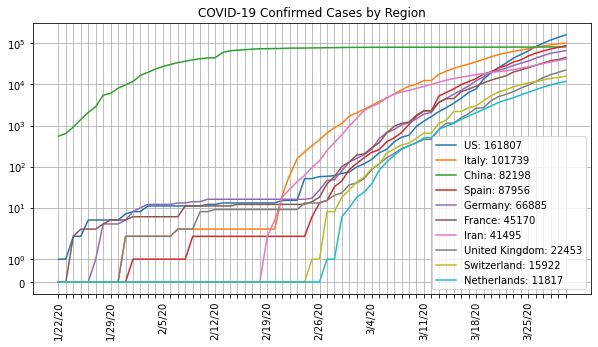

In [8]:
ts_confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

ts_only_confirmed_df = ts_confirmed_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_confirmed_df)[-2], ascending=False)

plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title("COVID-19 Confirmed Cases by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

for region in ts_only_confirmed_df.index[:legend_size]:
  ax.plot(ts_only_confirmed_df.loc[region], label=f"{region}: {ts_only_confirmed_df.loc[region][-1]}")

ax.legend()
plt.yscale("symlog")

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

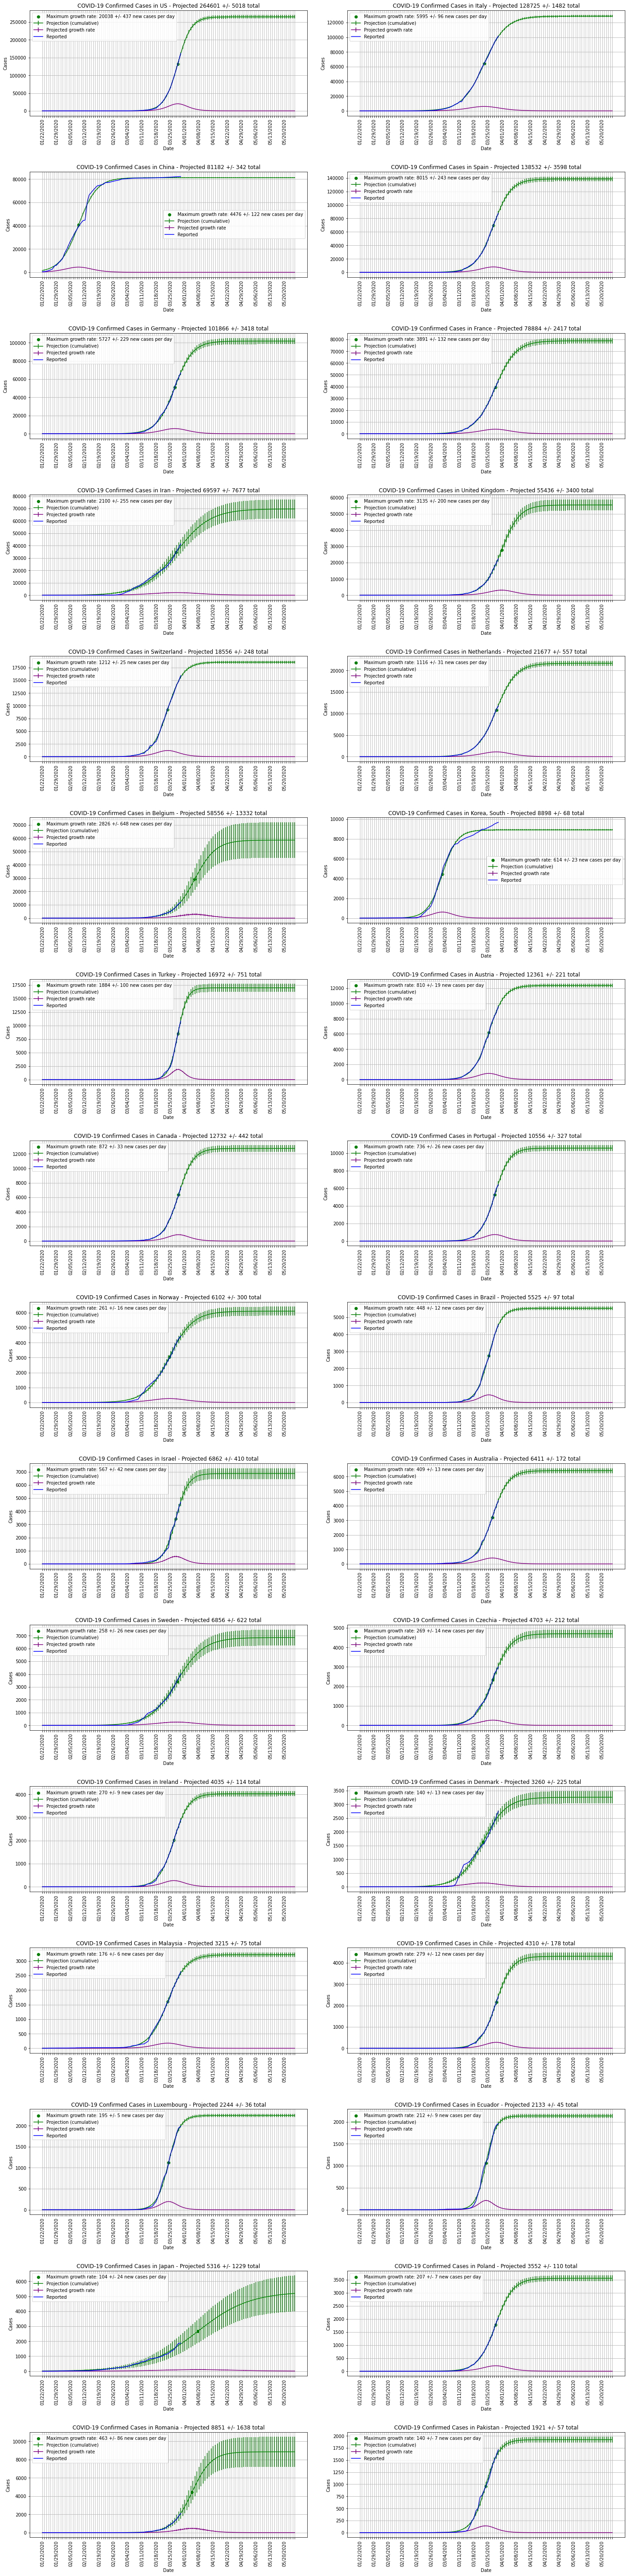

In [9]:
plot_top_n_countries = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_only_confirmed_df[:min(plot_top_n_countries, len(ts_only_confirmed_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)
  """initial_guesses = [min_a, regional_ts.max()/2, 0]
  while True:
    try:
      popt, pcov = curve_fit(sigmoid, *zip(*enumerate(regional_ts)), p0=initial_guesses)
      break
    except RuntimeError: # Couldn't optimize after 800 adjustments...
      initial_guesses[1] = (initial_guesses[1] + 1) * 1.5
  
  convergent = all([param > 0 for param in popt]) and all([invcov != 0 for invcov in 1/pcov.flatten()])
  
  if convergent:
    u_popt = [ufloat(*val_pair) for val_pair in zip(popt, np.sqrt(np.diag(pcov)))]
    curve = lambda x: usigmoid(x, *u_popt)
    
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)"""
  
  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  """current_ax.set_title(f"COVID-19 Confirmed Cases in {region} - {'Projection unavailable' if not convergent else f'Projected {int(u_popt[1].nominal_value)} +/- {int(u_popt[1].std_dev)} total'}")"""
  current_ax.set_title(f"COVID-19 Confirmed Cases in {region} - {'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} +/- {int(u_popt[1].std_dev)} total'}")
  current_ax.set_ylabel("Cases")
  current_ax.set_xlabel("Date")

  """min_a = min(min_a, popt[0])"""

  days_to_plot = 125

  """if convergent:"""
  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev for u_y in u_ys], label="Projection (cumulative)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev for u_y_prime in u_ys_prime], label="Projected growth rate", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value)} +/- {int(inflection_y.std_dev)} new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

In [10]:
# This is no longer available due to JHU CSSE removing per-state time series data.

"""
ts_us_confirmed_df = ts_confirmed_df[ts_confirmed_df["Country/Region"] == "US"]

ts_us_confirmed_df = ts_us_confirmed_df.drop(["Country/Region", "Lat", "Long"], axis=1).groupby("Province/State").sum().sort_values(list(ts_us_confirmed_df)[-1], ascending=False)

legend_size = 10
scale = 10, 7

fig, ax = plt.subplots(1, 1, figsize=scale)

i = 0
for area in ts_us_confirmed_df.index:
  ax.plot(ts_us_confirmed_df.loc[area], label=(f"{area}: {ts_us_confirmed_df.loc[area][-1]}" if i < legend_size else None))
  i += 1

plt.yscale("symlog")
ax.grid()

ax.legend()

day_zero = datetime(2020, 1, 22, 0, 0)

ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(len(ts_us_confirmed_df.columns))])

i = 0
for label in ax.get_xmajorticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.setp(ax.get_xmajorticklabels(), rotation=90)

ax.set_title("COVID-19 Confirmed Cases in the United States by State/Region")

plt.show()
"""

'\nts_us_confirmed_df = ts_confirmed_df[ts_confirmed_df["Country/Region"] == "US"]\n\nts_us_confirmed_df = ts_us_confirmed_df.drop(["Country/Region", "Lat", "Long"], axis=1).groupby("Province/State").sum().sort_values(list(ts_us_confirmed_df)[-1], ascending=False)\n\nlegend_size = 10\nscale = 10, 7\n\nfig, ax = plt.subplots(1, 1, figsize=scale)\n\ni = 0\nfor area in ts_us_confirmed_df.index:\n  ax.plot(ts_us_confirmed_df.loc[area], label=(f"{area}: {ts_us_confirmed_df.loc[area][-1]}" if i < legend_size else None))\n  i += 1\n\nplt.yscale("symlog")\nax.grid()\n\nax.legend()\n\nday_zero = datetime(2020, 1, 22, 0, 0)\n\nax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(len(ts_us_confirmed_df.columns))])\n\ni = 0\nfor label in ax.get_xmajorticklabels():\n  if i % 7 != 0:\n    label.set_visible(False)\n  i += 1\n\nplt.setp(ax.get_xmajorticklabels(), rotation=90)\n\nax.set_title("COVID-19 Confirmed Cases in the United States by State/Region")\n\nplt.show(

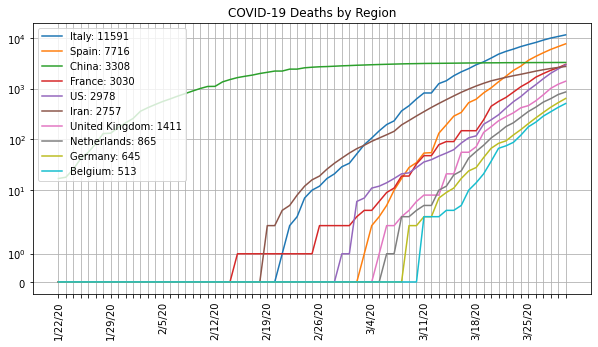

In [11]:
ts_deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

ts_only_deaths_df = ts_deaths_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_deaths_df)[-1], ascending=False)

plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title("COVID-19 Deaths by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

for region in ts_only_deaths_df.index[:legend_size]:
  ax.plot(ts_only_deaths_df.loc[region], label=f"{region}: {ts_only_deaths_df.loc[region][-1]}")

ax.legend()
plt.yscale("symlog")

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

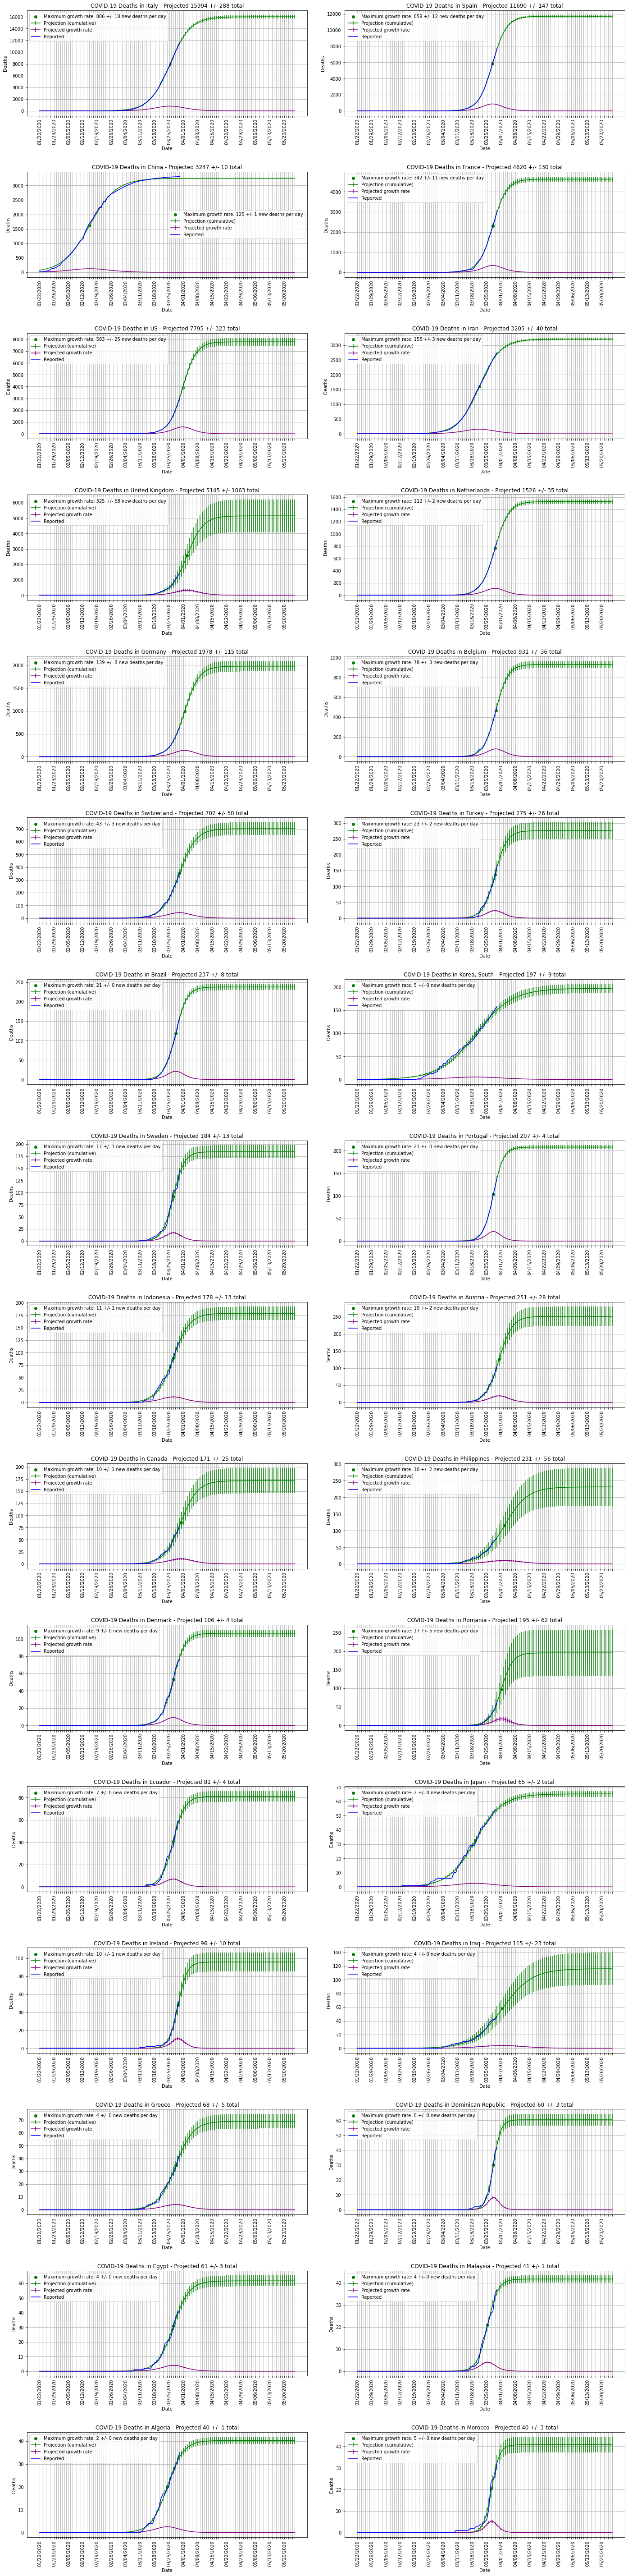

In [12]:
plot_top_n_countries = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_only_deaths_df[:min(plot_top_n_countries, len(ts_only_deaths_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)
  
  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"COVID-19 Deaths in {region} - {'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} +/- {int(u_popt[1].std_dev)} total'}")
  current_ax.set_ylabel("Deaths")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(x) for x in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev for u_y in u_ys], label="Projection (cumulative)", color="green")
    u_ys_prime = [curve_derivative(x) for x in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev for u_y_prime in u_ys_prime], label="Projected growth rate", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value)} +/- {int(inflection_y.std_dev)} new deaths per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

In [55]:
ts_only_consol_deaths_df = ts_deaths_df.drop(["Lat", "Long"], axis=1).sum()[1:]

ts_only_consol_deaths_df

1/22/20       17
1/23/20       18
1/24/20       26
1/25/20       42
1/26/20       56
           ...  
3/26/20    23970
3/27/20    27198
3/28/20    30652
3/29/20    33925
3/30/20    37582
Length: 69, dtype: object

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


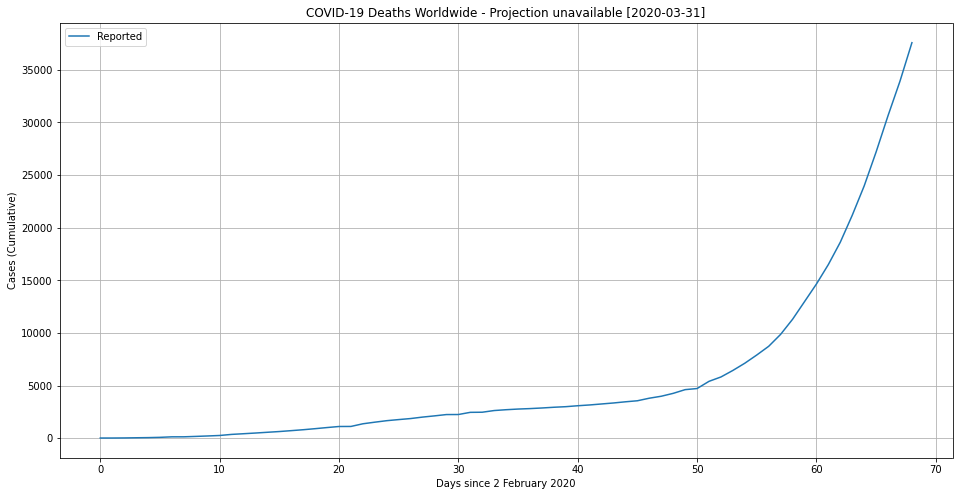

In [54]:
u_popt = fit_growth(sigmoid, *zip(*enumerate(ts_only_consol_deaths_df)))

if u_popt is not None:
  curve = lambda x: usigmoid(x, *u_popt)

# Prediction.
plt.figure(figsize=(16, 8))
if u_popt is not None:
  u_ys = [curve(x) for x in range(200)]
  plt.errorbar(x=range(len(u_ys)), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev for u_y in u_ys], label="Projection")
plt.errorbar(x=range(ts_only_consol_deaths_df.size), y=ts_only_consol_deaths_df, label="Reported")

plt.title(f"COVID-19 Deaths Worldwide - {'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} +/- {int(u_popt[1].std_dev)} total'} [{date.today()}]")
plt.grid()
plt.xlabel("Days since 2 February 2020")
plt.ylabel("Cases (Cumulative)")
#plt.yscale("symlog")
plt.legend()

plt.show()

In [0]:
# This is no longer available due to JHU CSSE removing per-state time series data.

"""
plot_top_n_regions = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_us_confirmed_df[:min(plot_top_n_regions, len(ts_us_confirmed_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

min_a = 0

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  initial_guesses = [min_a, regional_ts.max()/2, 0]
  while True:
    try:
      popt, pcov = curve_fit(sigmoid, *zip(*enumerate(regional_ts)), p0=initial_guesses)
      break
    except RuntimeError: # Couldn't optimize after 800 adjustments...
      initial_guesses[1] = (initial_guesses[1] + 1) * 1.5
  
  convergent = all([param > 0 for param in popt]) and all([invcov != 0 for invcov in 1/pcov.flatten()])
  
  if convergent:
    u_popt = [ufloat(*val_pair) for val_pair in zip(popt, np.sqrt(np.diag(pcov)))]
    curve = lambda x: usigmoid(x, *u_popt)
    
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"COVID-19 Confirmed Cases in {region} - {'Projection unavailable' if not convergent else f'Projected {int(u_popt[1].nominal_value)} +/- {int(u_popt[1].std_dev)} total'}")
  current_ax.set_ylabel("Cases")
  current_ax.set_xlabel("Date")

  min_a = min(min_a, popt[0])

  days_to_plot = 125

  if convergent:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev for u_y in u_ys], label="Projection (cumulative)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev for u_y_prime in u_ys_prime], label="Projected growth rate", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=popt[0], y=sigmoid(popt[0], *popt), label=f"Maximum growth rate: {int(inflection_y.nominal_value)} +/- {int(inflection_y.std_dev)} new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()
"""

In [0]:
ts_us_deaths_df = ts_deaths_df[ts_deaths_df["Country/Region"] == "US"]

ts_us_deaths_df = ts_us_deaths_df.drop(["Country/Region", "Lat", "Long"], axis=1).groupby("Province/State").sum().sort_values(list(ts_us_deaths_df)[-1], ascending=False)

In [0]:
# This is no longer available due to JHU CSSE removing per-state time series data.

"""
plot_top_n_regions = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_us_deaths_df[:min(plot_top_n_regions, len(ts_us_deaths_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

min_a = 0

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  initial_guesses = [min_a, regional_ts.max()/2, 0]
  while True:
    try:
      popt, pcov = curve_fit(sigmoid, *zip(*enumerate(regional_ts)), p0=initial_guesses)
      break
    except RuntimeError: # Couldn't optimize after 800 adjustments...
      initial_guesses[1] = (initial_guesses[1] + 1) * 1.5
  
  convergent = all([param > 0 for param in popt]) and all([invcov != 0 for invcov in 1/pcov.flatten()])
  
  if convergent:
    u_popt = [ufloat(*val_pair) for val_pair in zip(popt, np.sqrt(np.diag(pcov)))]
    curve = lambda x: usigmoid(x, *u_popt)
    
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"COVID-19 Deaths in {region} - {'Projection unavailable' if not convergent else f'Projected {int(u_popt[1].nominal_value)} +/- {int(u_popt[1].std_dev)} total'}")
  current_ax.set_ylabel("Deaths")
  current_ax.set_xlabel("Date")

  min_a = min(min_a, popt[0])

  days_to_plot = 125

  if convergent:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev for u_y in u_ys], label="Projection (cumulative)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev for u_y_prime in u_ys_prime], label="Projected growth rate", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=popt[0], y=sigmoid(popt[0], *popt), label=f"Maximum growth rate: {int(inflection_y.nominal_value)} +/- {int(inflection_y.std_dev)} new deaths per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()
"""